In [1]:
#импортируем нужные нам библиотеки
import warnings                                 
warnings.filterwarnings('ignore')
#импортируем нужные нам библиотеки
import numpy as np                              
import pandas as pd                             
import matplotlib.pyplot as plt                  
import seaborn as sns                                         


from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

%matplotlib inline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

#загружаем данные
data = pd.read_excel('005_example.xlsx', axis=1)

In [2]:
#загружаем модель FbPropher
from fbprophet import Prophet

In [3]:
#данные
data

,date_id,good_id,ship_store_id,price,promo,sale,promo_price,holiday,owner_id
0,2018-09-16,149045,40,699,0,1,699,0,2
1,2018-03-17,149045,40,599,0,0,599,0,2
2,2018-03-23,149045,40,599,0,0,599,0,2
3,2017-07-25,149045,40,599,0,2,599,0,2
4,2018-10-04,173544,13,1399,0,0,1399,0,2
...,...,...,...,...,...,...,...,...,...
529572,2018-04-01,149079,77,399,0,6,0,0,9
529573,2018-03-29,149079,77,399,0,2,0,0,9
529574,2018-10-01,149079,77,499,0,0,0,0,9
529575,2019-05-27,149079,77,499,0,0,0,0,9


In [4]:
data['year'] = pd.DatetimeIndex(data['date_id']).year
data['month'] = pd.DatetimeIndex(data['date_id']).month
data['day'] = pd.DatetimeIndex(data['date_id']).day
data['WeekOfYear'] = pd.DatetimeIndex(data['date_id']).weekofyear

In [5]:
#группируем данные по неделям
table = data.groupby('date_id')['sale'].sum()
#сортируем данные от самых поздних дат до самых ранних
table = table.sort_index(ascending = False)
#создаем датафрейм
df = pd.DataFrame({'ds': table.index, 'y': table.values})
df

,ds,y
0,2019-12-01,906
1,2019-11-30,1292
2,2019-11-29,733
3,2019-11-28,469
4,2019-11-27,512
...,...,...
1029,2017-02-05,147
1030,2017-02-04,154
1031,2017-02-03,70
1032,2017-02-02,59


In [6]:
#импортируем модуль datetime
import datetime

In [7]:
#Приступаем к созданию тестовой и обучающей выборки. 
#В описании задания сказано, что модель должна рассчитывать прогноз на 45, 46, 47, 48 календарные недели
#разбиваем нашу выбору по нужному временному интервалу
split_date = datetime.datetime.strptime("2019-11-01", '%Y-%m-%d')

In [8]:
#Создаем тренировочную и тестовую выборку данных
d_train = df[df['ds'] < split_date]

d_test = df[df['ds'] >= split_date]

In [9]:
#У модели Facebook Prophet существует ряд гиперпараметров, 
#настройка оптимальных значений которых позволит увеличить эффективность прогнозирования
#однако при работе с моделью Prophet'а возникает две трудности


#Первая трудность заключается в том, что создание прогноза на уровне "номер магазина + номер товара" занимаем большое количество времени
#Если добавить к этому еще задачу, при которой модель также будет подбирать оптимальные гиперпараметры для каждого прогноза, 
#то время работы модели также увеличится в разы. К тому же мой компьютер довольно слабый для поставленных задача. 
#Поэтому было принято решение подобрать оптимальные на общих данных, агрегированных по неделям, и уже потом их использовать для каждой модели

In [10]:
#Загружаем нашу модель
my_model = Prophet(interval_width = 0.95, yearly_seasonality=True, daily_seasonality=True, 
                   changepoint_prior_scale=6.5, n_changepoints = 37)

In [11]:
#Фитим модель на данных
my_model.fit(d_train)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [12]:
#Прогнозируем по тестовым данным
forecast = my_model.predict(d_test)

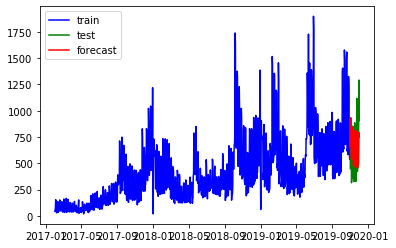

In [13]:
#Строим простой график факта к прогнозу
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})
plt.plot(d_train['ds'], d_train['y'], linestyle='-', color='b', label='train')
plt.plot(d_test['ds'], d_test['y'], linestyle='-', color='g', label='test')
plt.plot(forecast['ds'], forecast['yhat'], linestyle='-', color='r', label='forecast')
plt.legend()

In [14]:
#Создаем датафрейм с сравнением данных по прогнозу и факту и высчитываем MAPE
results = d_test.copy()
results['forecast'] = forecast['yhat'].values
results['MAPE'] = abs((results['y'] - results['forecast']) / results['y'] * 100)
results

,ds,y,forecast,MAPE
0,2019-12-01,906,653.288064,27.893150
1,2019-11-30,1292,931.381072,27.911682
2,2019-11-29,733,878.899724,19.904464
3,2019-11-28,469,549.726052,17.212378
4,2019-11-27,512,542.875831,6.030436
5,2019-11-26,469,547.636738,16.766895
6,2019-11-25,424,541.769834,27.775904
7,2019-11-24,1025,556.648780,45.692802
8,2019-11-23,1118,842.870392,24.609088
9,2019-11-22,567,798.915372,40.902182


In [15]:
#Показатель MAPE составил 33.73. Это лучший результат с установленным гиперпараметром
mape = results['MAPE'].sum()/31
mape

33.73302666013747

In [16]:
#Добавляем значения верхних и нижних границ
def compare_join(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

compare_df = compare_join(results, forecast)
compare_df

,yhat,yhat_lower,yhat_upper,y,forecast,MAPE
ds,,,,,,
2019-11-01,653.288064,384.563517,894.624950,450,753.091916,67.353759
2019-11-02,931.381072,672.902898,1208.258849,934,792.255072,15.176116
2019-11-03,878.899724,614.373443,1128.103607,905,499.876086,44.765073
2019-11-04,549.726052,307.683259,798.437849,727,477.364247,34.337793
2019-11-05,542.875831,281.973930,805.234357,315,474.056745,50.494205
2019-11-06,547.636738,280.892014,806.107819,353,458.561830,29.904201
2019-11-07,541.769834,283.544796,806.758500,359,453.150868,26.225868
2019-11-08,556.648780,292.920581,815.793531,390,768.620387,97.082151
2019-11-09,842.870392,592.734951,1095.147306,854,806.090468,5.610015


In [17]:
#Визуализация прогноза
init_notebook_mode(connected=True)

def show_forecast(cmp_df, num_predictions, num_values, title):   
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Нижняя граница', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="aqua"))
    upper_bound = create_go('Вверхняя граница', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="aqua"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Прогноз', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Факт', 'y', num_values,
                       marker=dict(color="red"))
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='sales'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(compare_df, 31, 100, 'Прогноз продаж')

In [18]:
split_date = datetime.datetime.strptime("2019-11-01", '%Y-%m-%d')

In [19]:
data_test = data[data['date_id'] >= split_date]
data_test['store_and_id'] = data.apply(lambda x: f"{x['ship_store_id']} + {x['good_id']}", axis=1) 
                        

In [20]:
data_test

,date_id,good_id,ship_store_id,price,promo,sale,promo_price,holiday,owner_id,year,month,day,WeekOfYear,store_and_id
16,2019-11-09,173541,63,1299,0,0,1299,0,2,2019,11,9,45,63 + 173541
17,2019-11-15,173541,63,1299,0,0,1299,0,2,2019,11,15,46,63 + 173541
81,2019-11-11,162604,12,899,0,0,5299,0,2,2019,11,11,46,12 + 162604
82,2019-11-17,162604,12,899,0,0,4999,0,2,2019,11,17,46,12 + 162604
86,2019-11-14,162604,12,899,0,0,4999,0,2,2019,11,14,46,12 + 162604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529555,2019-11-06,96474,39,2599,0,0,0,0,2,2019,11,6,45,39 + 96474
529556,2019-11-12,96474,39,2599,0,0,0,0,2,2019,11,12,46,39 + 96474
529569,2019-11-26,149079,77,499,1,2,399,0,9,2019,11,26,48,77 + 149079
529570,2019-11-20,149079,77,499,0,0,0,0,9,2019,11,20,47,77 + 149079


In [21]:
#Однако при построении прогнозов для группы "номер магазина" + "номер товара" возникла проблема. 
#Оптимальные значения гиперпараметров (в нашем случае changepoint_prior_scale и n_changepoints), которые мы
#подобрали на агрегированных данных, показали плохой результат с дефолтными параметрами модели FB Prophet.
#В связи с тем, что это было бы весьма долго подбирать подходящие гиперпараметры для каждого прогноза, было решено запустить модель на дефолтных параметрах.

In [22]:
#Создание прогноза
#Теперь для создания прогноза по парам "магазин + товар" создадим спеицальную функцию.

mape_slovar = {}
main_slovar_for_sale = {}
#модель по магазинам
def funcck(data):
    #создаем новый столбец - результат конъюкции признаков "номер магазина" и "номер товара"
    data['store_and_id'] = data.apply(lambda x: f"{x['ship_store_id']} + {x['good_id']}", axis=1) 
    #запуск итерации по уникальным значениям столбца (коньюкция номера магазина и номера товара)
    for i in data['store_and_id'].unique():
        my_model = Prophet(interval_width = 0.95, yearly_seasonality=True, daily_seasonality=True)
        #выбираем данные с указанным значением номера магазина и товара
        table = data[data['store_and_id'] == i]
        #группируем данные по продажам в неделю
        table = table.groupby('date_id')['sale'].sum()
        #устанавливаем значения индекса датафрейма нашими значениями datetime 
        table = table.sort_index(ascending = False)
        #создаем датафрейм для нашей модели со столбцами ds и y
        df = pd.DataFrame({'ds': table.index, 'y': table.values})
        #указываем промежуток для временного сплита
        split_date = datetime.datetime.strptime("2019-11-01", '%Y-%m-%d')
        #делим на тестовую и тренировочную выборку
        d_train = df[df['ds'] < split_date]
        d_test = df[df['ds'] >= split_date]
        #фитим модель
        my_model.fit(d_train)
        #прогнозируем по новым данным
        forecast = my_model.predict(d_test)    
        results = d_test.copy()
        #выделяем полученные спрогнозированные данные
        results['fcst'] = forecast['yhat'].values.round()       
        results['fcst'] = abs(results['fcst'])
        #находим значение MAPE на каждую неделю прогноза
        results['MAPE'] = abs(results['y'] - results['fcst']) / (results[['y','fcst']].max(axis=1) + 0.01)
        #находим среднее значение Mape по всему прогнозу магазина + товара
        mape = results['MAPE'].sum()/len(results['MAPE'])
        mape_slovar[i] = mape
        results['time+good+shop'] = results.apply(lambda x: f"{x['ds']} + {i}", axis=1)
        slovar_for_sales = results.groupby('time+good+shop')['y'].sum().to_dict()
        main_slovar_for_sale.update(slovar_for_sales)                                         
    data_test['MAPE'] = data_test['store_and_id'].replace(mape_slovar) 
    data_test['time+good+shop'] = data_test.apply(lambda x: f"{x['date_id']} + {x['store_and_id']}", axis=1)
    data_test['y'] = data_test['time+good+shop'].replace(main_slovar_for_sale) 
    return data_test

#Используем функцию прогноза на данных
end_table = funcck(data)

In [23]:
#Выделяем нужные колонки
Final = end_table[['good_id','ship_store_id', 'date_id', 'promo', 'sale', 'y']]

In [24]:
Final.rename(columns={'y': 'sale_predict'}, inplace=True)

In [25]:
Final

,good_id,ship_store_id,date_id,promo,sale,sale_predict
16,173541,63,2019-11-09,0,0,0
17,173541,63,2019-11-15,0,0,0
81,162604,12,2019-11-11,0,0,0
82,162604,12,2019-11-17,0,0,0
86,162604,12,2019-11-14,0,0,0
...,...,...,...,...,...,...
529555,96474,39,2019-11-06,0,0,0
529556,96474,39,2019-11-12,0,0,0
529569,149079,77,2019-11-26,1,2,2
529570,149079,77,2019-11-20,0,0,0


In [26]:
#Выгружаем в ексель
Final.to_excel("Hoff_excel.xlsx")

In [27]:
#Создаем столбец со значением 1 - MAPE
end_table['1 - Mape'] = 1 - end_table['MAPE']
#Высчитываем среднее значение параметра 1 - MAPE
end_table['1 - Mape'].mean()

0.5083090805200461

In [28]:
#Выделяем значения недели
end_table['WeekOfYear'] = pd.DatetimeIndex(end_table['date_id']).weekofyear

In [29]:
#4 прогнозируемые недели
end_table['WeekOfYear'].unique()

array([45, 46, 47, 44, 48], dtype=int64)

In [30]:
#Значения 1 - Mape для 4 недель
for i in end_table['WeekOfYear'].unique():
    print('Номер недели', end_table[end_table['WeekOfYear'] == i]['1 - Mape'].mean())

Номер недели 0.508309080520061
Номер недели 0.5083090805200589
Номер недели 0.5083090805200599
Номер недели 0.5083090805200591
Номер недели 0.5083090805200582
